# EE5601 Representation Learning

Assignment 2
===================

In [219]:
import numpy as np 
from matplotlib import pyplot as plt 

In [220]:
%matplotlib inline

# Q1) Logic Gate Implementations

## XOR gate (^) ; AND gate (&) ; OR gate (|);

In [270]:
# Setting up...

# Generating Training Dataset and its labels(True Outputs)
N = 10000
ip_training = np.random.randint(2,size=(2,N))
ip_training_noisy = ip_training.astype(float) + np.random.normal(0,0.001,size=(2,N))
labels = np.zeros((1,N))
for i in range(N):
    labels[0,i] = ip_training[0,i]&ip_training[1,i] #Change'^'(XOR) operator to '&'for(AND)gate;'|'for(OR)gate

# Activation function
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def del_sigmoid(x):
    return x * (1 - x)

ipLNeurons, hLNeurons, opLNeurons = 2,2,1

#Random weights and bias initialization
hl_weights = np.random.uniform(size=(hLNeurons,ipLNeurons))
hl_bias =np.random.uniform(size=(hLNeurons,1))
opl_weights = np.random.uniform(size=(opLNeurons,hLNeurons))
opl_bias = np.random.uniform(size=(opLNeurons,1))



In [271]:
# Algorithms

def fwprop(X,W1,W2,B1,B2):
    #print(np.dot(W1,X)+B1)
    H = sigmoid(np.dot(W1,X)+B1)
    Y = sigmoid(np.dot(W2,H)+B2)
    return H,Y

def cost(Y,Y_expected):
    err = Y-Y_expected
    return np.dot(err,err.T)/2

def backprop(X,H,Y,Y_expected,W1,W2,B1,B2,Lambda):
    delta_opl = np.multiply(Y-Y_expected,del_sigmoid(Y))
    delta_hl = np.multiply(np.dot(W2.T,delta_opl),del_sigmoid(H))
    B2_new = B2 - Lambda*np.reshape(np.sum(delta_opl,axis=1),[-1,1])/N
    W2_new = W2 - Lambda*np.dot(delta_opl,H.T)
    B1_new = B1 - Lambda*np.reshape(np.sum(delta_hl,axis=1),[-1,1])/N
    W1_new = W1 - Lambda*np.dot(delta_hl,X.T)
    return W1_new,W2_new,B1_new,B2_new
    
# Training
C = []
W1,W2,B1,B2 = hl_weights,opl_weights,hl_bias,opl_bias
Lambda = 0.01
iters = 1000 #Increase number of iterations if necessary...
i=0
while(i<iters):
    #print(i)
    X = ip_training_noisy
    H,Y = fwprop(X,W1,W2,B1,B2)
    #print(H)
    C.append(cost(Y,labels))
    W1,W2,B1,B2 = backprop(X,H,Y,labels,W1,W2,B1,B2,Lambda) #updating weights
    i+=1


In [272]:
#Calculating Accuracy...
correct_predictions = (labels==np.round(Y)).sum()
print("Percentage Accuracy:-",end=" ")
print(str(correct_predictions*100/(N))+"%")

Percentage Accuracy:- 100.0%


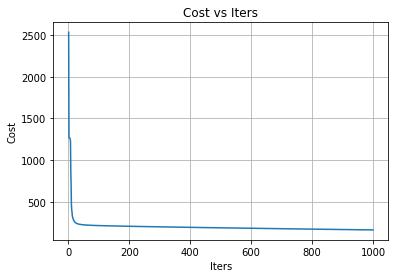

In [273]:
C = np.squeeze(C)
I = np.arange(1,iters+1)

plt.plot(I,C)
plt.xlabel("Iters")
plt.ylabel("Cost")
plt.title("Cost vs Iters")
plt.grid()
plt.show()

In [36]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Q2) Implementing Sparse Autoencoder

In [190]:
import numpy as np 
from matplotlib import pyplot as plt 
import idx2numpy

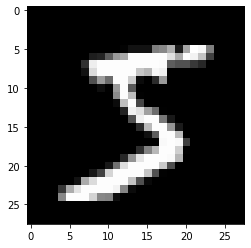

In [191]:
training_file = 'train-images-idx3-ubyte'
imagearray = idx2numpy.convert_from_file(training_file)
plt.imshow(imagearray[0], cmap=plt.get_cmap('gray'))
N,w,h = np.shape(imagearray)

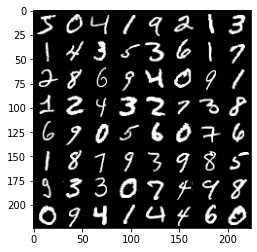

In [192]:
def plot(data, size = 64):
    img_c, img_w, img_h = imagearray.shape
    imgmatrix = np.zeros((int(np.sqrt(size)*img_w),int(np.sqrt(size)*img_h)))  
    for i in range(size):
        x = int(i/np.sqrt(size))
        y = int(i%np.sqrt(size))
        imgmatrix[x*28:(x+1)*28,y*28:(y+1)*28]=data[i]
    plt.subplot(10, 10, 1)
    plt.imshow(imgmatrix, cmap='gray')
    plt.show()
    return
plot(imagearray,64)

In [193]:
# Setting up...

B = 2000 #Batch Size
input_arr = np.copy(imagearray[:B,:,:])
input_arr.resize((B,w*h))
X = np.transpose(np.copy(input_arr))/255 #each column of X is vector containing pixels of each image
#print(np.shape(X))
labels = np.copy(X)

# Activation function
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def del_sigmoid(x):
    return x * (1 - x)

ipLNeurons, hLNeurons, opLNeurons = w*h,400,w*h #alter number of hidden layer neurons from here

#Random weights and bias initialization
hl_weights = np.random.uniform(size=(hLNeurons,ipLNeurons))
hl_bias =np.random.uniform(size=(hLNeurons,1))
opl_weights = np.random.uniform(size=(opLNeurons,hLNeurons))
opl_bias = np.random.uniform(size=(opLNeurons,1))


In [194]:
# Algorithms

def fwprop_sparse(X,W1,W2,B1,B2):
    H = sigmoid(np.matmul(W1,X)+B1)
    Y = sigmoid(np.matmul(W2,H)+B2) 
    return H,Y

def cost_sparse(Y,Y_expected,V,Beta,p,size):
    err = Y-Y_expected
    err1 = np.trace(np.dot(err,err.T))
    err2 = 0
    for i in range(len(V)):
        err2 += p*np.log(p/(V[i,0]+1e-10)+1e-10) + (1-p)*np.log((1-p)/(1-V[i,0]+1e-10)+1e-10)
    return (err1+Beta*err2)/2
    

def backprop_sparse(X,H,Y,Y_expected,W1,W2,B1,B2,Lambda,V,Beta,p):
    delta_opl = np.multiply(Y-Y_expected,del_sigmoid(Y))
    delta_sparse = np.multiply(Beta*(-p/(V+1e-10) + (1-p)/(1-V+1e-10)),del_sigmoid(H))
    delta_hl = np.multiply(np.dot(W2.T,delta_opl),del_sigmoid(H)) + delta_sparse
    B2_new = B2 - Lambda*np.reshape(np.sum(delta_opl,axis=1),[-1,1])/N
    W2_new = W2 - Lambda*np.dot(delta_opl,H.T)
    B1_new = B1 - Lambda*np.reshape(np.sum(delta_hl,axis=1),[-1,1])/N
    W1_new = W1 - Lambda*np.dot(delta_hl,X.T)
    return W1_new,W2_new,B1_new,B2_new

    
# Training
# NOTE:This takes around 5-10 mins....
C = []
p = 0.4 # Bernoulli parameter
Beta = 0.5 # Weight of the sparsity penalty term
W1,W2,B1,B2 = hl_weights,opl_weights,hl_bias,opl_bias 
Lambda = 0.1
iters = 1000
i=0
while(i<iters):
    #print(i)
    H,Y = fwprop_sparse(X,W1,W2,B1,B2)
    sV = np.reshape(np.sum(H, axis=1),[-1,1])/B  #Sparse Vector
    #C.append(cost_sparse(Y,labels,sV,Beta,p,hLNeurons)) 
    W1,W2,B1,B2 = backprop_sparse(X,H,Y,labels,W1,W2,B1,B2,Lambda,sV,Beta,p) #updating weights
    i+=1
    



<ipython-input-193-13f82cca6704>:12: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


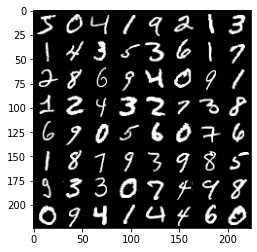

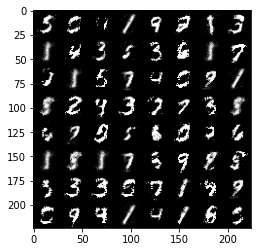

In [198]:
Y*=255
temp1 = []
for i in range(B):
    temp1.append(np.reshape(Y[:,i].T,(28,28)))
plot(imagearray,64)
plot(temp1,64)

In [197]:
# Uncomment the C.append command in the while loop of iterations and run it to add costs to the list C
# Only then run this command to plot the cost with iterations...
C = np.squeeze(C)
I = np.arange(1,iters+1)

plt.plot(I,C)
plt.xlabel("Iters")
plt.ylabel("Cost")
plt.title("Cost vs Iters")
plt.grid()
plt.show()

'\nC = np.squeeze(C)\nI = np.arange(1,iters+1)\n\nplt.plot(I,C)\nplt.xlabel("Iters")\nplt.ylabel("Cost")\nplt.title("Cost vs Iters")\nplt.grid()\nplt.show()'

# Q3) Variational Autoencoder

## Please execute this part in google colaboratory....

In [199]:
import tensorflow as tf
import cv2
import gzip
from tensorflow import keras
from math import floor
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, Reshape, multiply, Embedding
from tensorflow.keras.layers import LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam

In [200]:
plt.rcParams["figure.figsize"] = 40, 40

In [203]:
f = gzip.open('train-images-idx3-ubyte.gz','r')

num_images = 60000

f.read(16)
buffer = f.read(num_images*28*28)
data = np.frombuffer(buffer, dtype=np.uint8).astype(np.float32)
data = data.reshape(num_images, 28, 28, 1)

trainx = np.zeros((num_images, 28, 28))
for i in range(num_images):
    image = np.asarray(data[i]).squeeze()
    trainx[i] = image/255.0
    #trainx[i] = cv2.resize(image, dsize=(14, 14))/255.0

trainx = np.reshape(trainx, (num_images, 28, 28, 1))


## Model Setup

In [ ]:
#Defining a custom keras layer to generate the gaussian distributions from mean and variances 
class params_to_gaussian(layers.Layer):
    def call(self, params):
        mean_z, var_z = params
        eps = tf.keras.backend.random_normal(tf.shape(mean_z))
        return mean_z +  eps * tf.exp(var_z/2)

# Defining a custom keras model for ease of training in tensorflow
class Custom_VAE(tf.keras.Model):
    def __init__(self, input_shape, latent_dim, **kwargs):
        super(Custom_VAE, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.encoder = self.Encoder(input_shape, latent_dim)
        self.decoder = self.Decoder(latent_dim)
      
    
    def Encoder(self, input_shape, latent_dim):
        encoder_input = Input(shape = input_shape, dtype = 'float32')
        input = Conv2D(10, (3,3), input_shape = input_shape, strides = (2,2), padding = 'same', activation = 'relu')(encoder_input)
        input = Dropout(0.3)(input)
        input = Conv2D(20, (3,3),  strides = 2, padding = 'same', activation = 'relu')(input)
        input = Dropout(0.3)(input)
        input = Conv2D(60, (3,3),  padding = 'valid', activation = 'relu')(input)
        input = Dropout(0.3)(input)
        input = Flatten()(input)
        input = Dense(500, activation='relu')(input)
        input = Dense(40, activation='relu')(input)
      
        mean_z = Dense(latent_dim)(input)
        var_z = Dense(latent_dim)(input)
        z = params_to_gaussian()([mean_z, var_z])
      
        encoder = Model([encoder_input], [mean_z, var_z, z])
        encoder.summary()
        return encoder
    
    def encoder_predict(self, data):
        return self.encoder(data)
    
    def decoder_predict(self, data):
        return self.decoder(data)
    
    def Decoder(self, latent_dim):
        decoder_input = Input(shape = (latent_dim,))
        decode = Dense(400, activation='relu')(decoder_input)
        decode = Dense(1500, activation='relu')(decode)
        decode = Reshape((5,5,60))(decode)
        decode = Conv2DTranspose(40, 3, activation='relu', padding='valid')(decode)
        decode = Dropout(0.3)(decode)
        decode = Conv2DTranspose(30, 3, strides=2, activation='relu', padding='same')(decode)
        decode = Dropout(0.3)(decode)
        decode = Conv2DTranspose(20,3, strides=2, activation='relu', padding='same')(decode)
        decode = Dropout(0.3)(decode)
        decode = Conv2DTranspose(1,3, activation='sigmoid', padding='same')(decode)
        decoder = Model(inputs=[decoder_input], outputs=[decode])
        decoder.summary()
        return decoder

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_var, z = self.encoder(data)
            recreated = self.decoder(z)
            loss_kl = -0.5* tf.reduce_mean(1+z_var-tf.exp(z_var)-tf.square(z_mean))
            reconstruct_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(data, recreated)) * data.shape[1]**2
            final_loss = reconstruct_loss + loss_kl

        gradients = tape.gradient(final_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        return {"Total_loss":final_loss, "KL_Loss":loss_kl, "ReconstructionLoss":reconstruct_loss}

vae = Custom_VAE((28,28,1), 2)
vae.compile(optimizer = tf.keras.optimizers.Adam())
vae.fit(trainx, epochs=100, batch_size=64, shuffle=True)

In [ ]:
def plot_latent(vae):
    gridx = np.linspace(-2, 2, 20)
    gridy = np.linspace(-2, 2, 20)
    #figure = np.zeros((20*28, 20*28), dtype='float32')
    for i in range(20):
        for j in range(20):
            #print(i,j)
            inp = np.reshape(np.array([[gridy[j], gridx[i]]]), (1,2))
            temp = vae.decoder_predict(inp)
            plt.subplot(20, 20, i*20+j+1)
            plt.imshow(temp[0,:,:,0], cmap='gray')
    plt.show()

plot_latent(vae)
